In [1]:
import os
from binance.client import Client
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

## The Automatic Correlated Coin List (TACCL)

This script will allow you to build a list of correlated coins around a coin of your choice. You will need: 

1. A binance API Key
2. A chosen Bridge coin (Default USDT)
3. A chosen start coin (Default QUMT)

The script will do the rest. This is not a trading recommendation. Trading is risky, do not trade with money you cannot afford to lose. 

#### Basic strategy: 

This script will gather the data for all coin pairs available for your bridge coin. It will sequentially choose coins that maximise the sum of the correlations. This heuristic should pick a good list of co-related coins. 

## Usage Instructions

Run every line of the script. The final two boxes will display the recommended coin list and the heatmap of the rolling average for the last 24 hours.

In [9]:
import os
import pandas as pd
from datetime import datetime, timedelta
import requests

def get_ticker_price(ticker_symbol: str, days: int, granularity: str):
    """
    Fetches historical price data for a given cryptocurrency ticker symbol from the Binance API.

    Parameters:
    - ticker_symbol (str): The ticker symbol for the cryptocurrency (e.g., 'BTCUSDT').
    - days (int): The number of days in the past to fetch data for.
    - granularity (str): The granularity of the klines/candlesticks data ('1m', '1h', '1d', etc.).

    Returns:
    - DataFrame: A pandas DataFrame containing the date and price data for the specified ticker symbol over the given time range.
    """
    # Calculate the start time as 'days' ago from the current time
    end_time = int(datetime.now().timestamp() * 1000)  # current time in milliseconds
    start_time = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)  # 'days' ago in milliseconds

    # API base URL
    base_url = "https://api.binance.com/api/v3/klines"

    # Parameters for the API request
    params = {
        'symbol': ticker_symbol,
        'interval': granularity,
        'startTime': start_time,
        'endTime': end_time
    }

    # Making the GET request to the Binance API
    response = requests.get(base_url, params=params)

    # Initialize lists to store the fetched data
    prices = []
    dates = []

    # Parse the JSON response
    data = response.json()
    for result in data:
        date = datetime.utcfromtimestamp(result[0] / 1000).strftime("%Y-%m-%d %H:%M:%S")
        price = float(result[1])
        dates.append(date)
        prices.append(price)

    # Creating a DataFrame
    coindata = pd.DataFrame({
        ticker_symbol: prices,
        'date': dates
    })

    return (coindata.reindex(columns=['date', ticker_symbol]))


In [10]:
def get_price_data(tickers, days = 1, granularity = "1m"):
    '''
    Collects price data from the binance server.
    '''
    failures = []
    coindata = get_ticker_price(tickers[0], days, granularity)
    for tick in tickers[1:]:
        newdata = get_ticker_price(tick, days, granularity)
        if not newdata.empty:
            coindata = coindata.merge(newdata, how ='left')
            
        else:
            failures.append(tick)
    print('The following coins do not have historical data')
    print(failures)
    return(coindata)

In [11]:
def take_rolling_average(coindata):

    RA = pd.DataFrame()

    for column in coindata:
        if column != 'date':
            RA[column] = coindata[column].rolling(window=3).mean()
    return(RA)

In [12]:
def pick_coins(start_ticker , day_corr , week_corr, two_week_corr, n):
    '''
    Takes your starting coin, then sequentially picks the coin that jointly maximises
    the correlation for the whole coin list.
    
    INPUT:
    start_ticker : STR : The ticker for a coin you wish to include in your list
    day_corr     : PD.CORR : daily correlation data
    week_corr    : PD.CORR : Weekly correlation data
    two_week_corr: PD.CORR : bi-weekly correlation data
    n            : INTEGER : number of coins to include in your list.
    '''
    
    coinlist = [start_ticker]
    for i in range(n-1):    
        new_day_corr = day_corr[~day_corr.index.isin(coinlist)]
        new_week_corr = week_corr[~week_corr.index.isin(coinlist)]
        new_two_week_corr = two_week_corr[~two_week_corr.index.isin(coinlist)]
        corrsum = pd.DataFrame()
        for coin in coinlist:
            if corrsum.empty:
                corrsum = new_day_corr[coin] + new_week_corr[coin] + new_two_week_corr[coin]
            else:
                corrsum += new_day_corr[coin] + new_week_corr[coin] + new_two_week_corr[coin]
                
        ind = corrsum.argmax()
        coinlist.append(new_day_corr.index[ind])
    return(coinlist)

In [16]:
## Select your bridge coin

In [13]:
bridge = 'USDT'

In [14]:
def get_only_bridge_tickers(bridge='USDT'):
    # Download ALL the coinpairs from binance
    exchange_info = requests.get("https://api.binance.com/api/v3/exchangeInfo").json()
    print(exchange_info)

    full_coin_list = []

    # Only keep the pairs to our bridge coin
    for s in exchange_info['symbols']:
        if s['symbol'].endswith(bridge):
            full_coin_list.append(s['symbol'][:-4])

    # List of words to eliminate futures markets coins
    forbidden_words = ['DOWN', 'UP', 'BULL', 'BEAR']
    for forbidden in forbidden_words:
        full_coin_list = [word for word in full_coin_list if forbidden not in word]

    # Alphabetical order because pretty :)
    full_coin_list.sort()

    # Collect the data for 3 different windows (1 day, 1 week, 2 weeks)
    # with granularity (1 minute, 1 hour ,2 hours)

    cointickers = [coin + bridge for coin in full_coin_list]
    return cointickers

## Data Collection  -- Only rerun if you change bridge coin --
This code downloads all the data from Binance for all coin pairs with your bridge. You only need to run this once if you keep the same bridge.

In [16]:
!pip install requests
import time
from datetime import datetime, timedelta

import pandas as pd
import requests
from binance import client
from matplotlib import pyplot as plt
cointickers= get_only_bridge_tickers()
day_data = get_price_data(cointickers, 1, "1m")
week_data = get_price_data(cointickers, 7, "1h")
two_week_data = get_price_data(cointickers, 14, "2h")

## Collect the percentage change for correlation measurements

day_data = day_data[day_data.columns.difference(['date'])].pct_change()
week_data = week_data[week_data.columns.difference(['date'])].pct_change()
two_week_data = two_week_data[two_week_data.columns.difference(['date'])].pct_change()

# Calculate the rolling average (RA3) for all the coins 

RA_day_data = take_rolling_average(day_data)
RA_week_data = take_rolling_average(week_data)
RA_2week_data = take_rolling_average(two_week_data)

# take the correlations of the rolling averages.
 
day_corr = RA_day_data.corr()
week_corr = RA_week_data.corr()
two_week_corr = RA_2week_data.corr()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



The following coins do not have historical data
['AIONUSDT', 'ANCUSDT', 'ANTUSDT', 'ANYUSDT', 'AUDUSDT', 'AUTOUSDT', 'BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BEAMUSDT', 'BETHUSDT', 'BKRWUSDT', 'BTCSTUSDT', 'BTGUSDT', 'BTSUSDT', 'BTTUSDT', 'BUSDUSDT', 'BZRXUSDT', 'COCOSUSDT', 'DAIUSDT', 'DNTUSDT', 'EPSUSDT', 'ERDUSDT', 'GBPUSDT', 'GTOUSDT', 'GXSUSDT', 'HCUSDT', 'HNTUSDT', 'KEEPUSDT', 'LENDUSDT', 'MCUSDT', 'MCOUSDT', 'MFTUSDT', 'MIRUSDT', 'MITHUSDT', 'MULTIUSDT', 'NANOUSDT', 'NBSUSDT', 'NEBLUSDT', 'NPXSUSDT', 'NUUSDT', 'PAXUSDT', 'PERLUSDT', 'PLAUSDT', 'POLYUSDT', 'RAMPUSDT', 'REPUSDT', 'RGTUSDT', 'SRMUSDT', 'STORMUSDT', 'STRATUSDT', 'SUSDUSDT', 'TCTUSDT', 'TOMOUSDT', 'TORNUSDT', 'TRIBEUSDT', 'TVKUSDT', 'USDSUSDT', 'USDSBUSDT', 'USTUSDT', 'VENUSDT', 'WTCUSDT', 'XMRUSDT', 'XZCUSDT', 'YFIIUSDT']
The following coins do not have historical data
['AIONUSDT', 'ANCUSDT', 'ANTUSDT', 'ANYUSDT', 'AUDUSDT', 'AUTOUSDT', 'BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BEAMUSDT', 'BETHUSDT', 'BKRWUSDT', 'BTCSTUS

C:\Users\Workstation X\AppData\Local\Temp\ipykernel_14740\4208321376.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  week_data = week_data[week_data.columns.difference(['date'])].pct_change()
C:\Users\Workstation X\AppData\Local\Temp\ipykernel_14740\4208321376.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  two_week_data = two_week_data[two_week_data.columns.difference(['date'])].pct_change()
C:\Users\Workstation X\AppData\Local\Temp\ipykernel_14740\3184828692.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

# Choose your Starting coin here
We will attempt to find a set of coins that are highly correlated with this coin. The reverse greedy algorithm works on the basis that we will try to find a bunch of coins that are highly correlated (which reduced long term risk) but which have short term noise. 

In [17]:
startcoin = 'XRP'

## Choose Size of list 
This is the number of coins you wish to have in your list.


In [18]:
size_of_list = 20

In [19]:
coinlist = pick_coins(startcoin + bridge, day_corr , week_corr , two_week_corr , size_of_list )

In [20]:
# calculate stds
scaled_day_data = (day_data  / day_data.max())
scaled_week_data = (week_data  / week_data.max()) 
scaled_two_week_data = (two_week_data  / two_week_data.max())

day_std = scaled_day_data.std()
week_std = scaled_week_data.std()
two_week_std = scaled_two_week_data.std()

## Looking for volatility in the coinlist
Volatility in the market can be useful for your strategy, but large overwhelming jumps show an unpredictability (or an underlying cause) you should be wary of and investigate.  

These histograms show the maximum jumps taken over a day period (checked per minute) and two weeks (checked per hour). If a coin shows huge volatility you may choose to exclude it from your coin list

Top 10 daily maximum jumps
XTZUSDT      0.018612
NEOUSDT      0.018192
GMXUSDT      0.018068
ETCUSDT      0.017744
BNTUSDT      0.017478
1INCHUSDT    0.016747
XRPUSDT      0.016260
LTCUSDT      0.015432
dtype: float64
Top 10 two weekly maximum jumps
SXPUSDT      0.101595
1INCHUSDT    0.101466
ETCUSDT      0.098144
NEOUSDT      0.096112
GMXUSDT      0.090455
XTZUSDT      0.088267
BALUSDT      0.087480
DASHUSDT     0.080088
dtype: float64


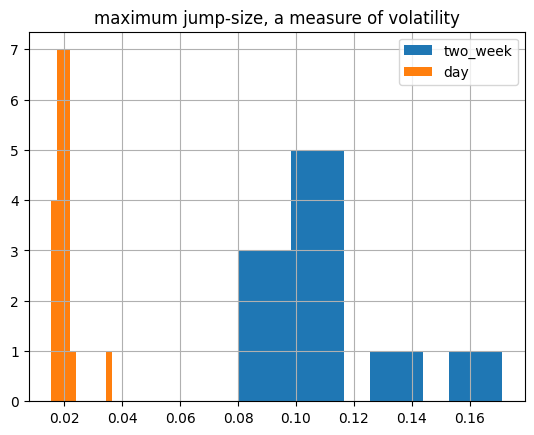

In [21]:
maxjumpday = day_data.max() - day_data.min()
maxjumptwoweek = two_week_data.max() - two_week_data.min()
maxjumptwoweek[coinlist].hist(label='two_week')
maxjumpday[coinlist].hist(label='day')
plt.title('maximum jump-size, a measure of volatility')
plt.legend()
print('Top 10 daily maximum jumps')
print(maxjumpday[coinlist].sort_values(ascending=False)[-8:])
print('Top 10 two weekly maximum jumps')
print(maxjumptwoweek[coinlist].sort_values(ascending=False)[-8:])

# TACCL result: 

This list is not a recommended trading list. Do not risk money if you are not sure what you are doing. 

In [22]:
coins = [coin.replace(bridge,'') for coin in coinlist]
for coin in coins:
    print(coin)

XRP
LTC
XLM
DASH
SNT
RVN
BNT
NEO
ETC
BADGER
BAL
BAT
1INCH
BAND
SXP
ONG
GMX
CHZ
XTZ
MANA


The rest of the code will plot the correlation matric for the rolling average of the selected coins.

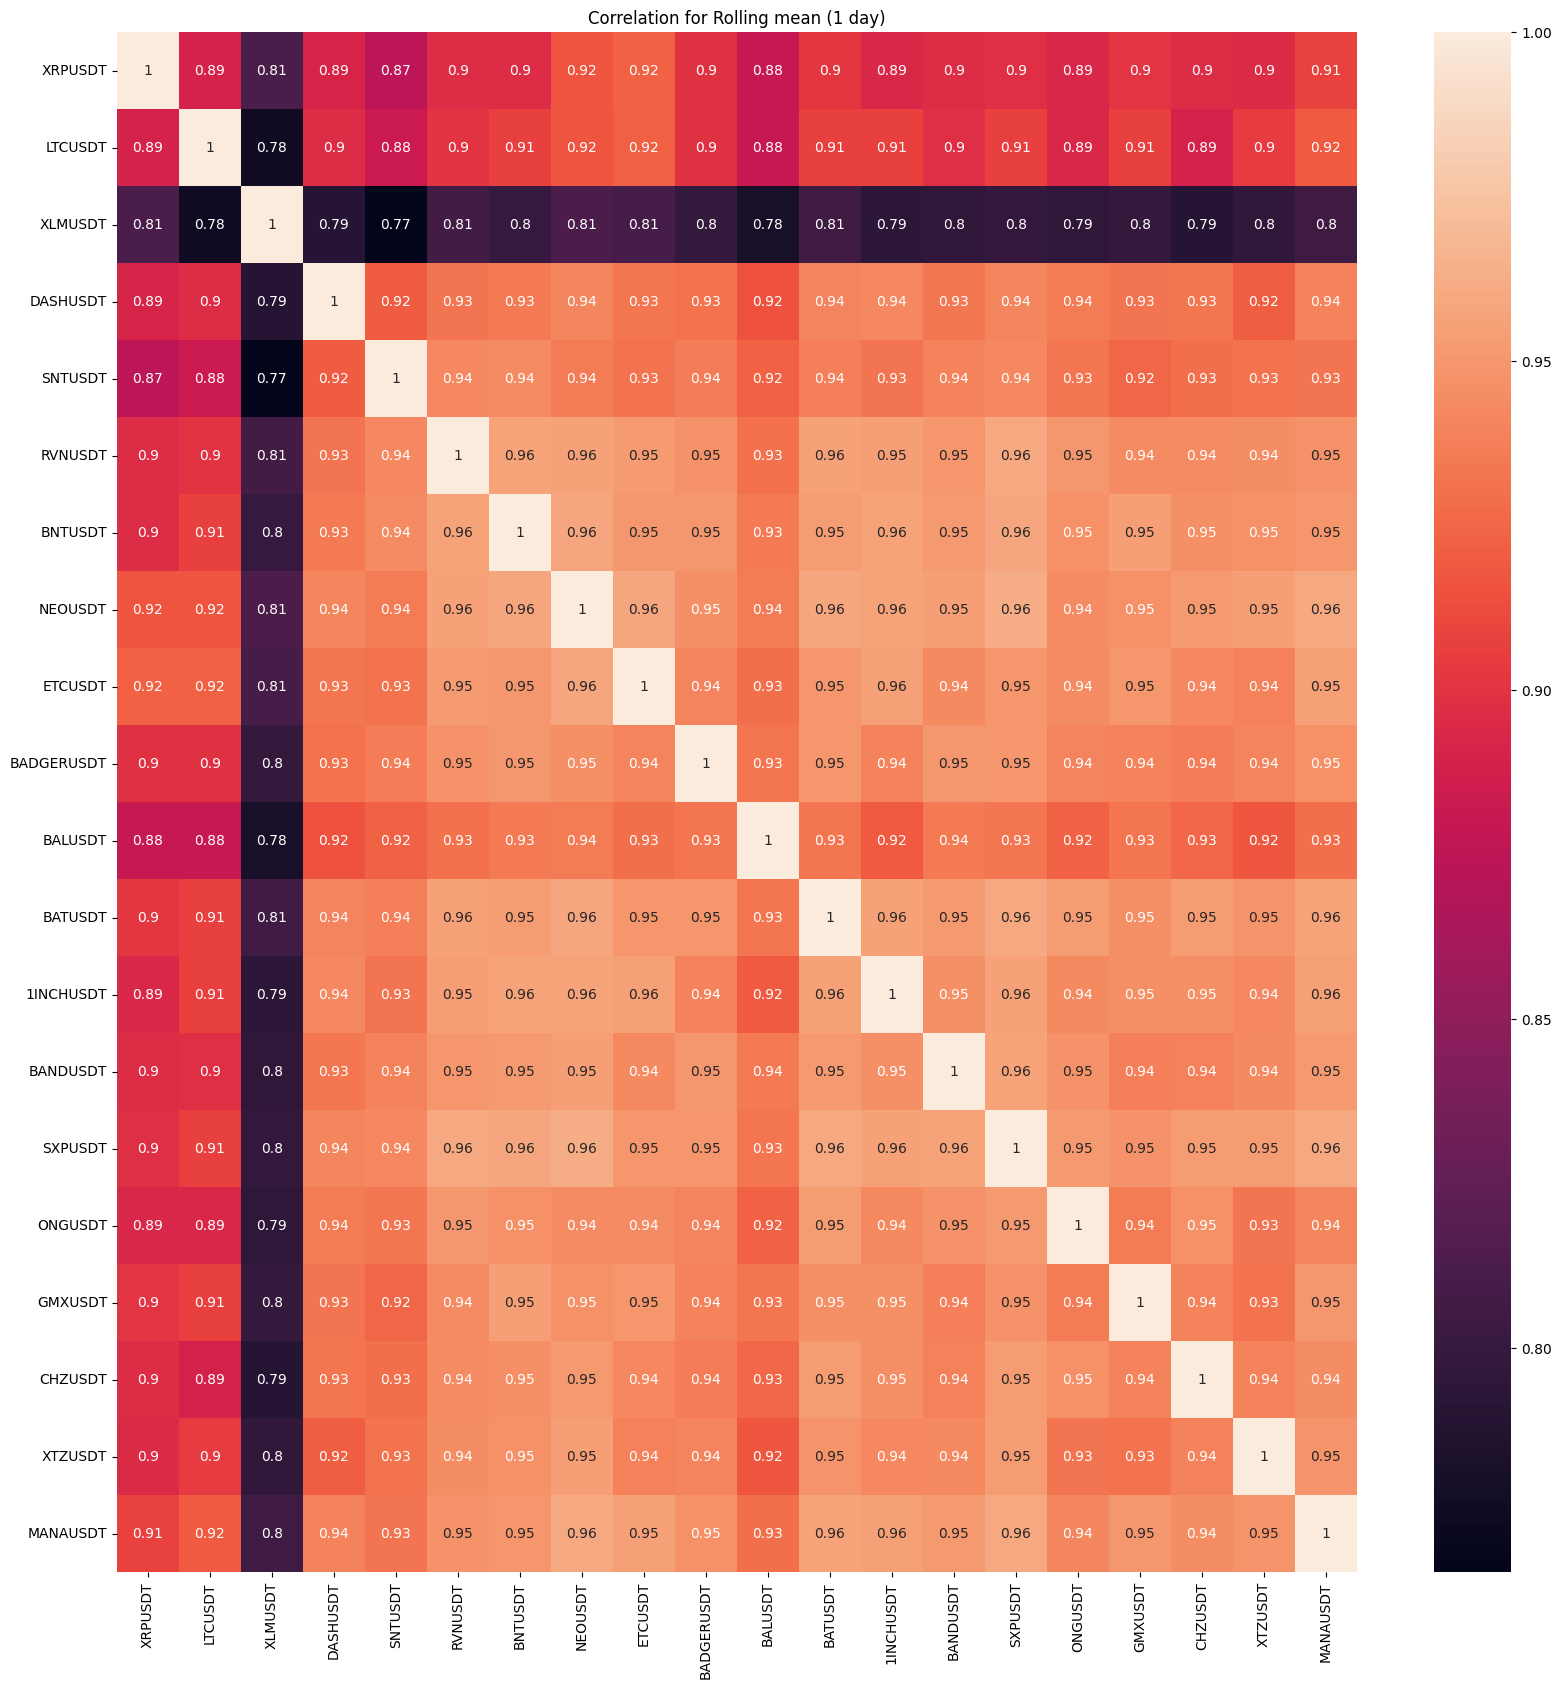

In [23]:
### Examine the trend of the rolling average
corrMatrixday = day_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixday, annot=True)
plt.title('Correlation for Rolling mean (1 day)')
plt.show()

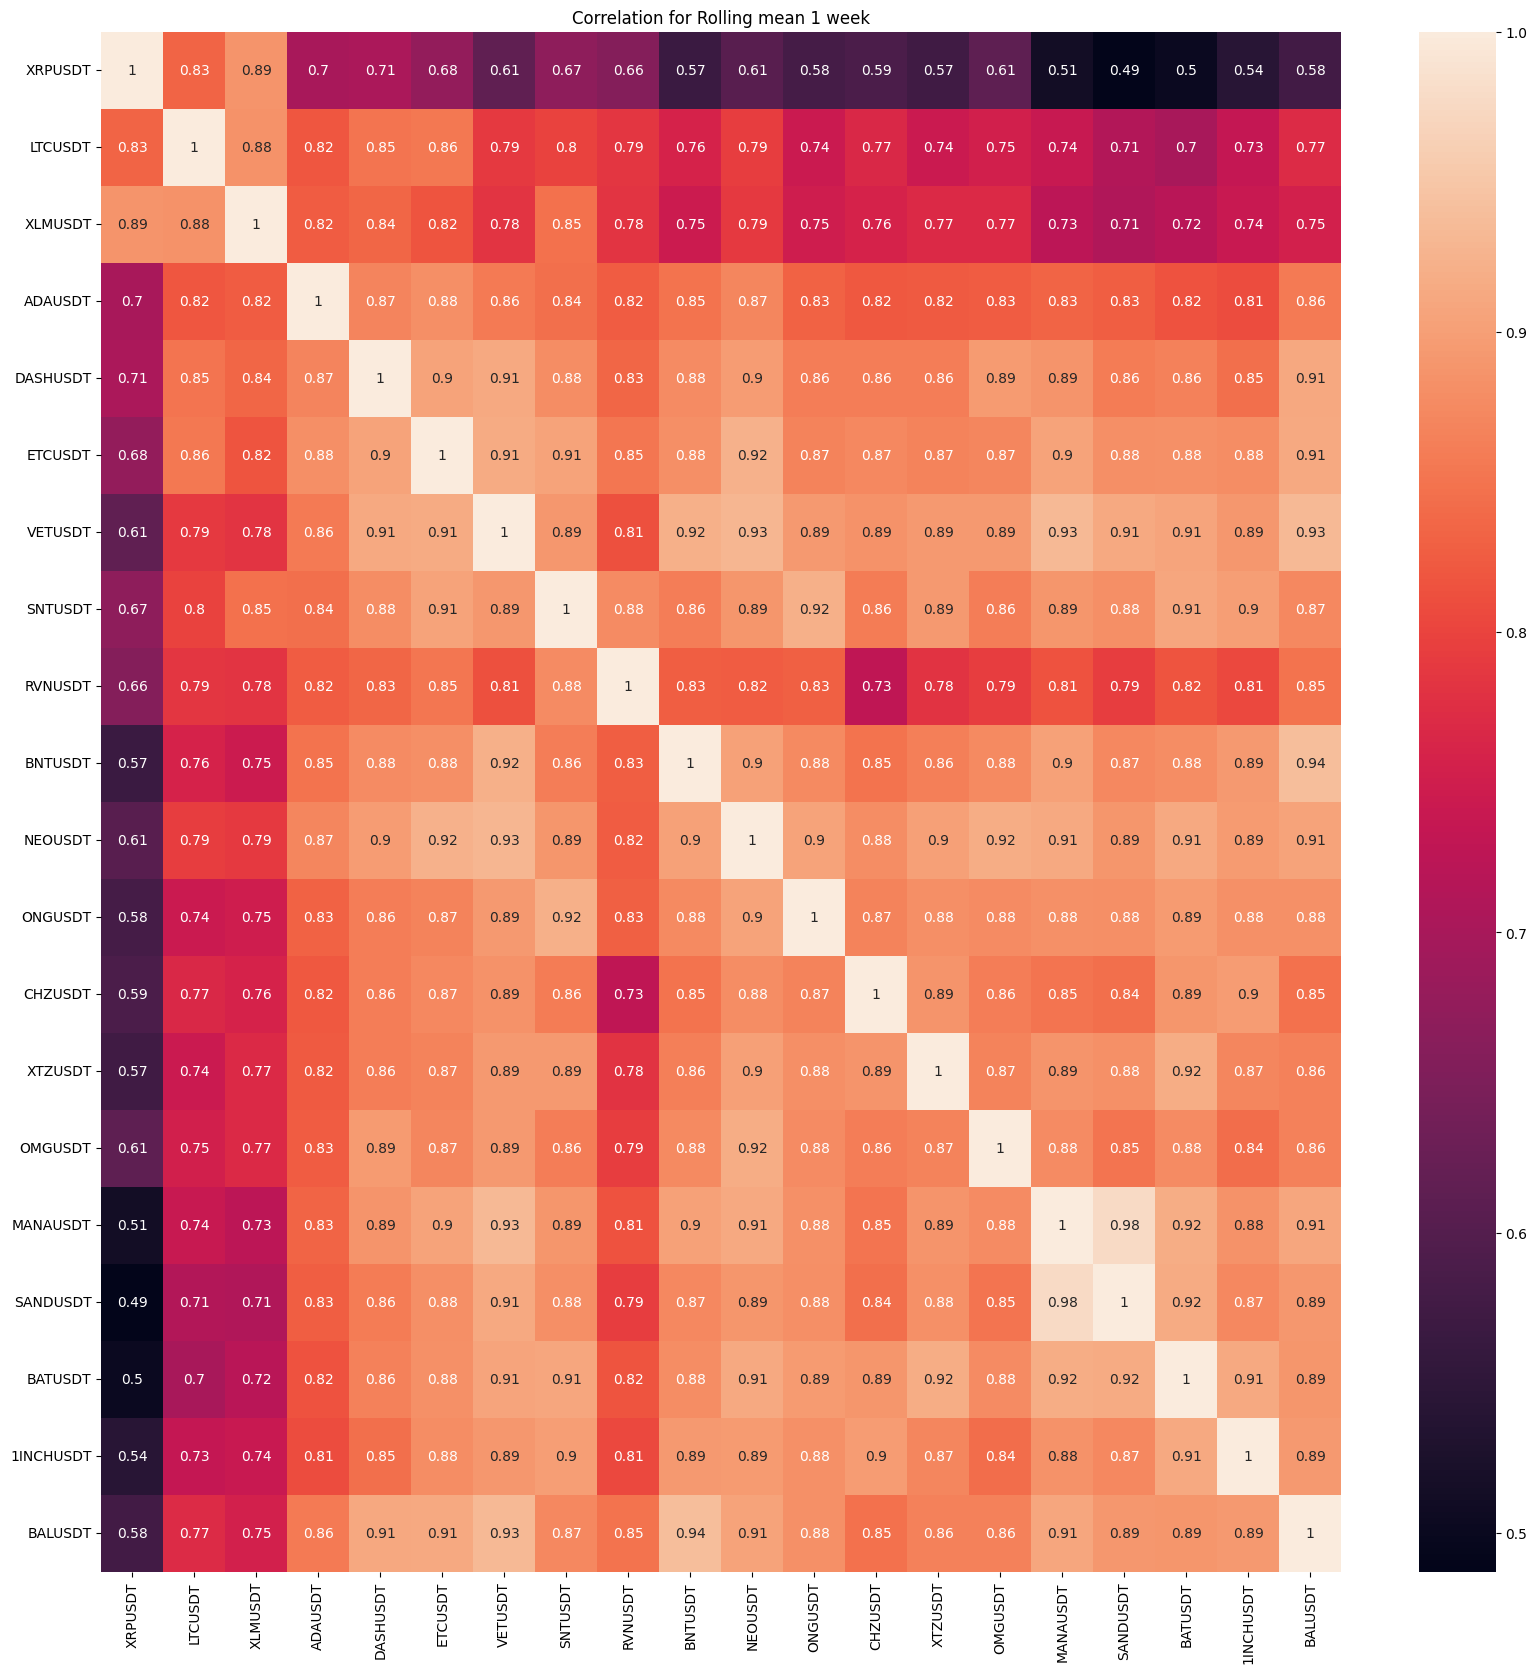

In [36]:
### Examine the trend of the rolling average
corrMatrixweek = week_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixweek, annot=True)
plt.title('Correlation for Rolling mean 1 week')
plt.show()

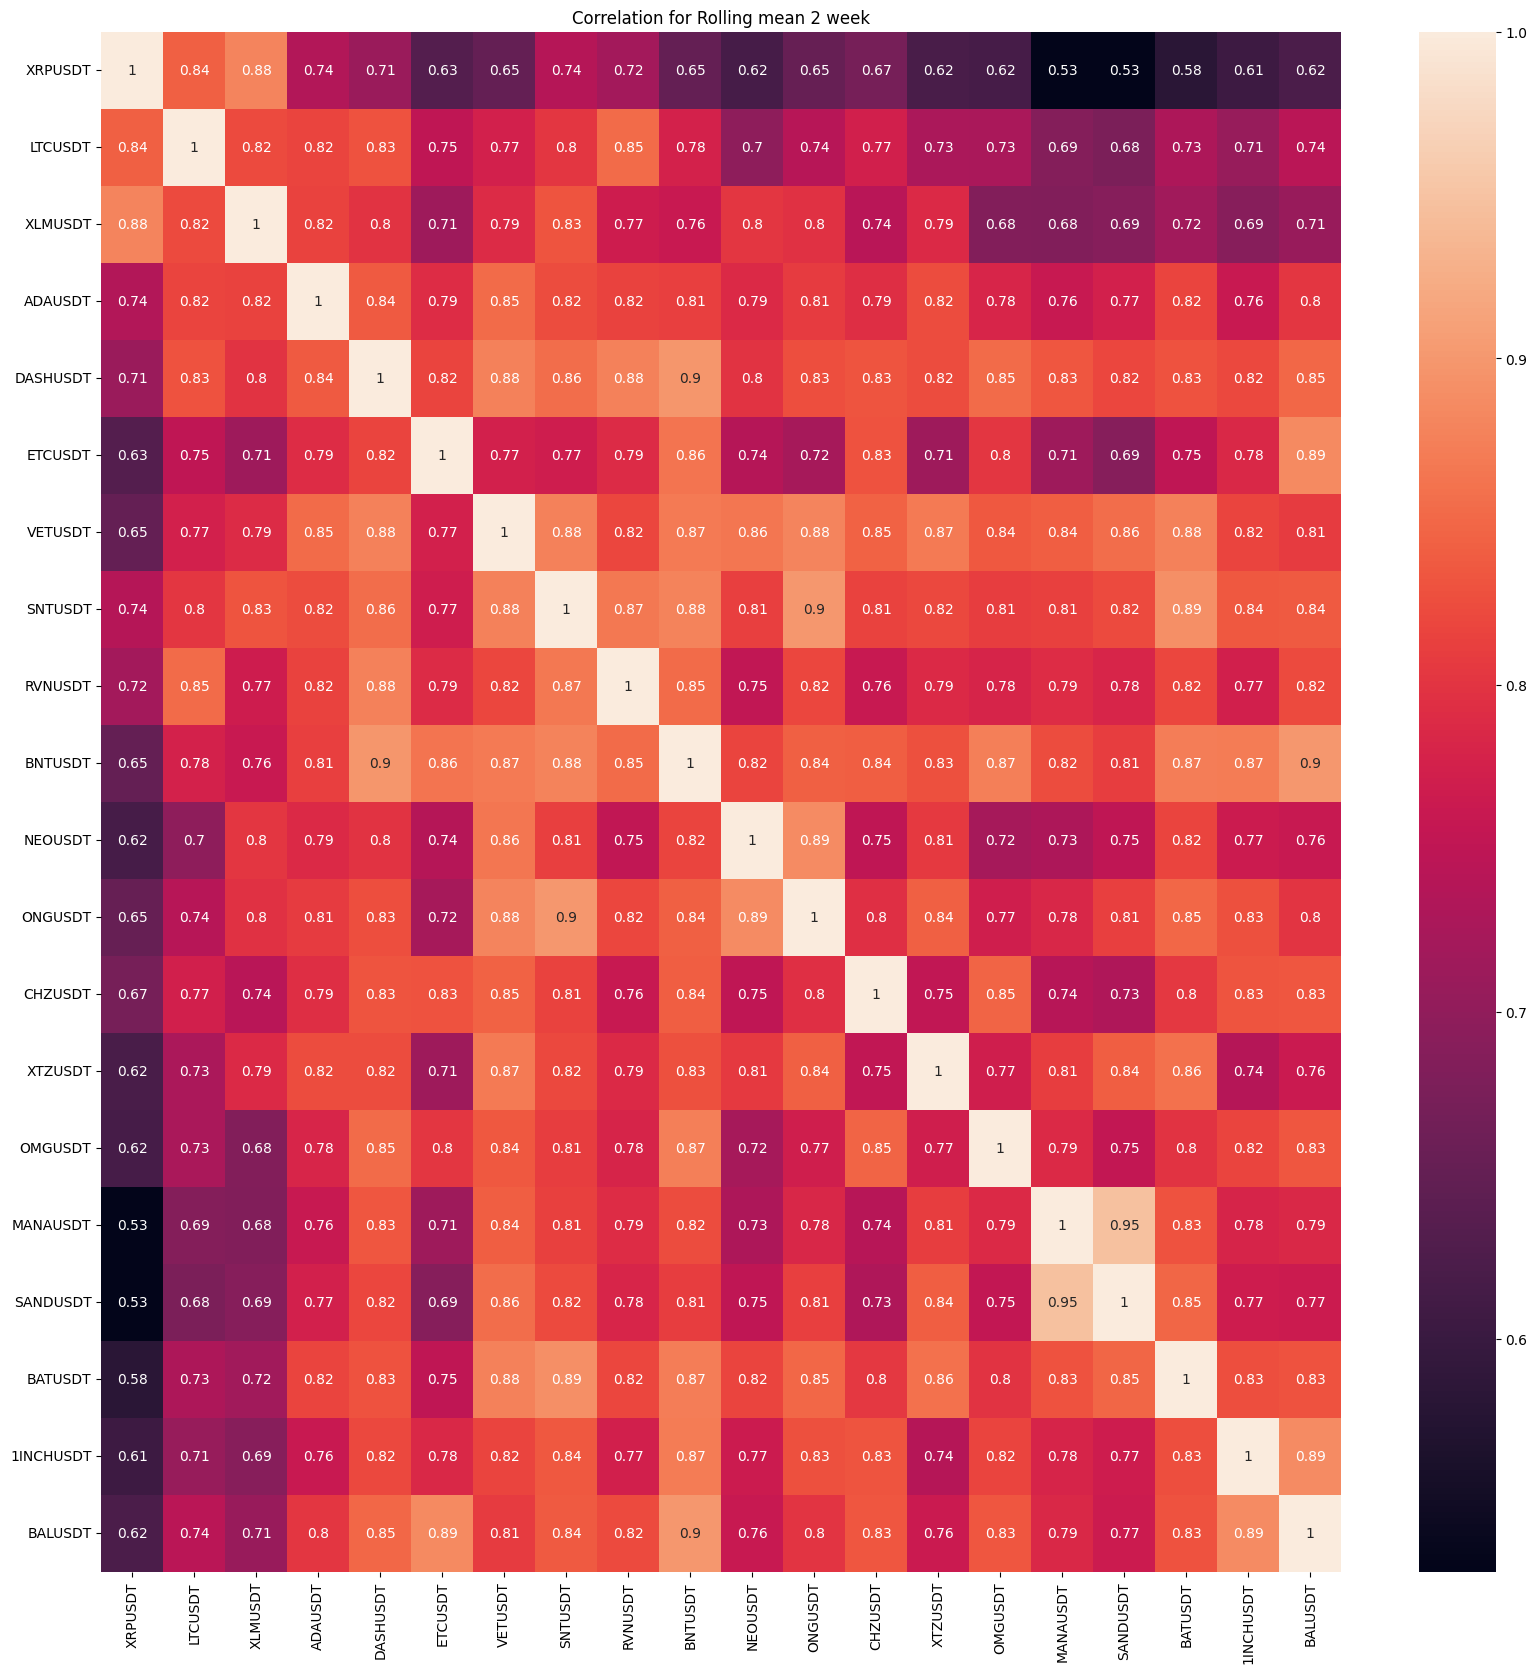

In [37]:
corrMatrixtwoweek = two_week_corr[coinlist].loc[coinlist]
fig = plt.figure(figsize=(20,20))
sn.heatmap(corrMatrixtwoweek, annot=True)
plt.title('Correlation for Rolling mean 2 week')
plt.show()

## Notes on correlation
For the Reverse Greedy Strategy you would like to see good long/mid-term correlation (a high number for the week and two-week) and a slightly lower correlation value for the daily. This implies you have a strong general trend but with noise to allow trading.

In [38]:
print(f"Day Correlation avg: {corrMatrixday.values[np.triu_indices_from(corrMatrixday.values,1)].mean()}")
print(f"Week Correlation avg: {corrMatrixweek.values[np.triu_indices_from(corrMatrixweek.values,1)].mean()}")
print(f"Two Week Correlation avg: {corrMatrixtwoweek.values[np.triu_indices_from(corrMatrixtwoweek.values,1)].mean()}")

Day Correlation avg: 0.8921724113052326
Week Correlation avg: 0.83103373397854
Two Week Correlation avg: 0.7879215561242068


## Trade Volume

A coin that trades less frequently is more likely to suffer from slippage (a difficulty in transacting away from a position in time to make profit) You should consider this when accepting a coin list

This script identifies if any of the coins in your list trade under 5million USD in the previous 24 hour period

In [40]:
volumedata = requests.get("https://api.binance.com/api/v1/ticker/24hr").json()

for data in volumedata:
    if data['symbol'] in coinlist:
        usdtradevol = float(data['volume'])*float(data['weightedAvgPrice'])
        print(data['symbol'] ,' 24hr trade volume is ' , usdtradevol,'USD')
        if usdtradevol<5E+6:
            print('Warning, low trade volumes can increase the probability of slippage')

NEOUSDT  24hr trade volume is  8864126.201056786 USD
LTCUSDT  24hr trade volume is  94794376.08641542 USD
ADAUSDT  24hr trade volume is  166335507.7752414 USD
XRPUSDT  24hr trade volume is  384699410.506311 USD
XLMUSDT  24hr trade volume is  23569148.866428997 USD
ETCUSDT  24hr trade volume is  55579810.8550392 USD
VETUSDT  24hr trade volume is  28001594.89816594 USD
ONGUSDT  24hr trade volume is  3720565.0928145596 USD
Warning, low trade volumes can increase the probability of slippage
BATUSDT  24hr trade volume is  4522683.9151155 USD
Warning, low trade volumes can increase the probability of slippage
DASHUSDT  24hr trade volume is  7010352.663934009 USD
OMGUSDT  24hr trade volume is  5719840.792150176 USD
CHZUSDT  24hr trade volume is  31409806.82875994 USD
XTZUSDT  24hr trade volume is  6686162.582060151 USD
RVNUSDT  24hr trade volume is  5686952.932470992 USD
BNTUSDT  24hr trade volume is  3854090.38833132 USD
Warning, low trade volumes can increase the probability of slippage
MAN